# ＣＢＩＲ

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print('device:',device)

batch_size = 1024

device: cuda:6


## 读取数据

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def dataLoader( istrain=True):
        trans = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize(mean, std)]
        )
        data_set = datasets.CIFAR100('./', train=istrain, transform=trans)
        return data_set

dataset = {}
for phase in ['train', 'val']:
    dataset[phase] = dataLoader(phase=='train')

dataloaders_dict = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['train', 'val']}


batchsize = 1024

len(dataloaders_dict['train']) = 49 = 48 \* 1024 + 848

len(dataloaders_dict['val']) = 10 = 9 \* 1024 + 784

In [4]:
# 不需要更新梯度
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

## 加载预训练的网络

In [6]:
# load network 预训练网络的结构
model_lo = models.resnet101()  # resnet原分类数为1000
model_lo.avgpool = nn.AvgPool2d(kernel_size=1, stride=1, padding=0)  # 忘了为什么改这层的结构了
model_lo.fc = nn.Linear(2048, 100)  # 训练时分类数为100

# load parameters
load_path = './acc_6057.pth'
model_lo.load_state_dict(torch.load(load_path))

# change network to get 1024-d feature
model_lo.fc = nn.Linear(2048, 1024)

# 不更新权重
set_parameter_requires_grad(model_lo)
model_lo.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## 提取特征，保存到本地

In [7]:
# save to loacl file
save_path = './cifar-100-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, dataloaders):
    since = time.time()
    res = []
         
    model.eval()

    # Iterate over data.
    for inputs, labels in dataloaders['train']:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        res.append(outputs)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return res

features = extract_features(model_lo, dataloaders_dict)

save_data(save_path, features)
print("Save features to %s" % (save_path))

Feature extraction complete in 0m 10s
Save features to ./cifar-100-train-resnet


## 图像搜索的准备

### １．计算余弦相似度 

In [8]:
def compute_cosine(data1, data2):
    csi = np.dot(data1, data2.T) / (np.linalg.norm(data1) * (np.linalg.norm(data2)))
    return csi[0]

# 计算目标图片与数据库中每张图像的余弦相似度
def search_similar(target, database):
    record = []
    for i in range(len(database)):
        for j in range(len(database[i])):
            record.append( compute_cosine(target, database[i][j].to('cpu').data.numpy()) )
    return record

### ２．提取目标图像的特征

In [9]:
# 提取目标图像的特征
def pred(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    model_lo.to('cpu')
    model_lo.eval()
    
    pre = model_lo(x)
    pre = pre.data.numpy()
    
    return pre

### ３．可视化cifar-100的图像

In [10]:
def pltimages(data):
    r = data[:1024].reshape(32, 32)
    g = data[1024:2048].reshape(32, 32)
    b = data[2048:3072].reshape(32, 32)
    i_np = np.dstack((r, g, b))
    plt.imshow(i_np)

In [12]:

def unpickle(file):
    fo = open(file, 'rb')
    entry = pk.load(fo, encoding='bytes')
    fo.close()
    return entry


''' 加载（读取）数据 '''
def load_data(file):
    ''' dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']) '''
    d = unpickle(file)
    data = d[b'data']
    names = d[b'filenames']
    fine_labels = d[b'coarse_labels']
    return names, data, fine_labels

## 图像搜索

target label: 31
find label:55
find label:31
find label:38
find label:31
find label:31


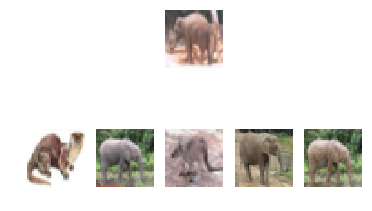

In [14]:
trainfile = './cifar-100-python/train'
testfile = './cifar-100-python/test'
names_database, data_database, label_database = load_data(trainfile)
names_test, data_test, label_test = load_data(testfile)

for _ in range(1):
    k = random.randint(0, len(dataset['val']))  # 10000张图中随机选一张测试
    
    print("target label:",dataset['val'][k][1])
    plt.subplot(253)
    pltimages(data_test[k])
    plt.axis('off')
    
    pre = pred(dataset['val'][k][0])
    res = search_similar(pre, features)
    sim = np.argsort(res)[-5:]  # 取最　

    i = 6
    for re in sim:
        plt.subplot(2, 5, i)      
        pltimages(data_database[re])
        print('found label:　%s' % (dataset['train'][re][1]))
        i += 1
        plt.axis('off')
    plt.show()

## 计算准确率

（其实没什么用）

In [15]:
count = 0
num = 10
for i in range(num):
    x = dataset['val'][i]
    pre = pred(x[0])
    res = search_similar(pre, features)
    sim = np.argsort(res)[-5:]
    for s in sim:
        if dataset['train'][s][1] == x[1]:
            count += 1

In [18]:
acc = count / (num * 5)
print(acc)

0.28


In [17]:
count

14